In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 829)
(466039, 1)
validation
(80707, 829)
(80707, 1)
test
(46831, 829)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 56s - loss: 0.0231 - STD: 6.5500e-05 - MAE: 0.1130

 4/47 [=>............................] - ETA: 9s - loss: 0.0171 - STD: 2.8379e-04 - MAE: 0.1030 

 8/47 [====>.........................] - ETA: 3s - loss: 0.0155 - STD: 3.8756e-04 - MAE: 0.0946

10/47 [=====>........................] - ETA: 3s - loss: 0.0150 - STD: 4.9809e-04 - MAE: 0.0939

11/47 [======>.......................] - ETA: 3s - loss: 0.0149 - STD: 5.5870e-04 - MAE: 0.0944

12/47 [======>.......................] - ETA: 3s - loss: 0.0148 - STD: 6.1415e-04 - MAE: 0.0944

14/47 [=======>......................] - ETA: 2s - loss: 0.0144 - STD: 7.0902e-04 - MAE: 0.0933

15/47 [========>.....................] - ETA: 2s - loss: 0.0143 - STD: 7.5001e-04 - MAE: 0.0927

16/47 [=========>....................] - ETA: 2s - loss: 0.0142 - STD: 7.8986e-04 - MAE: 0.0922

17/47 [=========>....................] - ETA: 2s - loss: 0.0142 - STD: 8.3343e-04 - MAE: 0.0918

18/47 [==========>...................] - ETA: 2s - loss: 0.0141 - STD: 8.7939e-04 - MAE: 0.0914

19/47 [===========>..................] - ETA: 2s - loss: 0.0140 - STD: 9.2921e-04 - MAE: 0.0911

20/47 [===========>..................] - ETA: 1s - loss: 0.0139 - STD: 9.8502e-04 - MAE: 0.0911

21/47 [============>.................] - ETA: 1s - loss: 0.0139 - STD: 0.0010 - MAE: 0.0911    

22/47 [=============>................] - ETA: 1s - loss: 0.0138 - STD: 0.0011 - MAE: 0.0911

23/47 [=============>................] - ETA: 1s - loss: 0.0138 - STD: 0.0012 - MAE: 0.0911

24/47 [==============>...............] - ETA: 1s - loss: 0.0137 - STD: 0.0012 - MAE: 0.0909

25/47 [==============>...............] - ETA: 1s - loss: 0.0136 - STD: 0.0013 - MAE: 0.0907

26/47 [===============>..............] - ETA: 1s - loss: 0.0136 - STD: 0.0013 - MAE: 0.0905

27/47 [================>.............] - ETA: 1s - loss: 0.0136 - STD: 0.0014 - MAE: 0.0902

28/47 [================>.............] - ETA: 1s - loss: 0.0135 - STD: 0.0015 - MAE: 0.0901

29/47 [=================>............] - ETA: 1s - loss: 0.0135 - STD: 0.0015 - MAE: 0.0899

30/47 [==================>...........] - ETA: 1s - loss: 0.0134 - STD: 0.0016 - MAE: 0.0898

31/47 [==================>...........] - ETA: 1s - loss: 0.0134 - STD: 0.0017 - MAE: 0.0898

32/47 [===================>..........] - ETA: 1s - loss: 0.0134 - STD: 0.0018 - MAE: 0.0898

33/47 [====================>.........] - ETA: 0s - loss: 0.0133 - STD: 0.0019 - MAE: 0.0897

35/47 [=====================>........] - ETA: 0s - loss: 0.0133 - STD: 0.0021 - MAE: 0.0895

36/47 [=====================>........] - ETA: 0s - loss: 0.0132 - STD: 0.0022 - MAE: 0.0894

37/47 [======================>.......] - ETA: 0s - loss: 0.0132 - STD: 0.0023 - MAE: 0.0892

38/47 [=======================>......] - ETA: 0s - loss: 0.0132 - STD: 0.0024 - MAE: 0.0891

39/47 [=======================>......] - ETA: 0s - loss: 0.0132 - STD: 0.0025 - MAE: 0.0890

41/47 [=========================>....] - ETA: 0s - loss: 0.0131 - STD: 0.0029 - MAE: 0.0889

42/47 [=========================>....] - ETA: 0s - loss: 0.0131 - STD: 0.0030 - MAE: 0.0888

43/47 [==========================>...] - ETA: 0s - loss: 0.0130 - STD: 0.0032 - MAE: 0.0887

44/47 [===========================>..] - ETA: 0s - loss: 0.0130 - STD: 0.0034 - MAE: 0.0886

45/47 [===========================>..] - ETA: 0s - loss: 0.0130 - STD: 0.0036 - MAE: 0.0885

46/47 [============================>.] - ETA: 0s - loss: 0.0129 - STD: 0.0039 - MAE: 0.0884

47/47 [==============================] - ETA: 0s - loss: 0.0129 - STD: 0.0041 - MAE: 0.0883

47/47 [==============================] - 5s 78ms/step - loss: 0.0129 - STD: 0.0041 - MAE: 0.0883 - val_loss: 0.0100 - val_STD: 0.0139 - val_MAE: 0.0753


Epoch 2/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0113 - STD: 0.0179 - MAE: 0.0832

 2/47 [>.............................] - ETA: 3s - loss: 0.0114 - STD: 0.0188 - MAE: 0.0835

 3/47 [>.............................] - ETA: 2s - loss: 0.0113 - STD: 0.0198 - MAE: 0.0835

 4/47 [=>............................] - ETA: 2s - loss: 0.0111 - STD: 0.0209 - MAE: 0.0831

 5/47 [==>...........................] - ETA: 2s - loss: 0.0111 - STD: 0.0219 - MAE: 0.0827

 6/47 [==>...........................] - ETA: 2s - loss: 0.0110 - STD: 0.0229 - MAE: 0.0823

 7/47 [===>..........................] - ETA: 2s - loss: 0.0110 - STD: 0.0239 - MAE: 0.0819

 8/47 [====>.........................] - ETA: 2s - loss: 0.0109 - STD: 0.0251 - MAE: 0.0816

 9/47 [====>.........................] - ETA: 2s - loss: 0.0109 - STD: 0.0264 - MAE: 0.0815

10/47 [=====>........................] - ETA: 2s - loss: 0.0109 - STD: 0.0276 - MAE: 0.0815

11/47 [======>.......................] - ETA: 2s - loss: 0.0108 - STD: 0.0289 - MAE: 0.0813

12/47 [======>.......................] - ETA: 2s - loss: 0.0108 - STD: 0.0301 - MAE: 0.0811

13/47 [=======>......................] - ETA: 2s - loss: 0.0107 - STD: 0.0312 - MAE: 0.0808

14/47 [=======>......................] - ETA: 2s - loss: 0.0107 - STD: 0.0323 - MAE: 0.0806

15/47 [========>.....................] - ETA: 2s - loss: 0.0107 - STD: 0.0334 - MAE: 0.0804

16/47 [=========>....................] - ETA: 1s - loss: 0.0106 - STD: 0.0346 - MAE: 0.0804

17/47 [=========>....................] - ETA: 1s - loss: 0.0106 - STD: 0.0355 - MAE: 0.0803

18/47 [==========>...................] - ETA: 1s - loss: 0.0106 - STD: 0.0364 - MAE: 0.0801

19/47 [===========>..................] - ETA: 1s - loss: 0.0106 - STD: 0.0372 - MAE: 0.0800

20/47 [===========>..................] - ETA: 1s - loss: 0.0106 - STD: 0.0379 - MAE: 0.0798

21/47 [============>.................] - ETA: 1s - loss: 0.0105 - STD: 0.0385 - MAE: 0.0796

22/47 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 0.0390 - MAE: 0.0796

23/47 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 0.0394 - MAE: 0.0795

24/47 [==============>...............] - ETA: 1s - loss: 0.0104 - STD: 0.0397 - MAE: 0.0793

25/47 [==============>...............] - ETA: 1s - loss: 0.0104 - STD: 0.0399 - MAE: 0.0791

26/47 [===============>..............] - ETA: 1s - loss: 0.0104 - STD: 0.0401 - MAE: 0.0789

27/47 [================>.............] - ETA: 1s - loss: 0.0104 - STD: 0.0403 - MAE: 0.0788

28/47 [================>.............] - ETA: 1s - loss: 0.0103 - STD: 0.0404 - MAE: 0.0787

29/47 [=================>............] - ETA: 1s - loss: 0.0103 - STD: 0.0405 - MAE: 0.0787

30/47 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0407 - MAE: 0.0786

31/47 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.0408 - MAE: 0.0784

32/47 [===================>..........] - ETA: 0s - loss: 0.0102 - STD: 0.0410 - MAE: 0.0782

33/47 [====================>.........] - ETA: 0s - loss: 0.0102 - STD: 0.0412 - MAE: 0.0781

34/47 [====================>.........] - ETA: 0s - loss: 0.0102 - STD: 0.0415 - MAE: 0.0779

35/47 [=====================>........] - ETA: 0s - loss: 0.0101 - STD: 0.0418 - MAE: 0.0778

37/47 [======================>.......] - ETA: 0s - loss: 0.0101 - STD: 0.0424 - MAE: 0.0775

38/47 [=======================>......] - ETA: 0s - loss: 0.0101 - STD: 0.0427 - MAE: 0.0774

39/47 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.0431 - MAE: 0.0773

40/47 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.0434 - MAE: 0.0771

41/47 [=========================>....] - ETA: 0s - loss: 0.0100 - STD: 0.0437 - MAE: 0.0769

42/47 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 0.0440 - MAE: 0.0768

43/47 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 0.0443 - MAE: 0.0766

44/47 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 0.0446 - MAE: 0.0764

45/47 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0448 - MAE: 0.0762

46/47 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0451 - MAE: 0.0760

47/47 [==============================] - ETA: 0s - loss: 0.0098 - STD: 0.0453 - MAE: 0.0759

47/47 [==============================] - 3s 66ms/step - loss: 0.0098 - STD: 0.0453 - MAE: 0.0759 - val_loss: 0.0068 - val_STD: 0.0505 - val_MAE: 0.0631


Epoch 3/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0080 - STD: 0.0572 - MAE: 0.0673

 2/47 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.0583 - MAE: 0.0681

 4/47 [=>............................] - ETA: 2s - loss: 0.0081 - STD: 0.0594 - MAE: 0.0687

 5/47 [==>...........................] - ETA: 2s - loss: 0.0081 - STD: 0.0590 - MAE: 0.0680

 6/47 [==>...........................] - ETA: 2s - loss: 0.0081 - STD: 0.0596 - MAE: 0.0677

 7/47 [===>..........................] - ETA: 2s - loss: 0.0081 - STD: 0.0613 - MAE: 0.0686

 8/47 [====>.........................] - ETA: 2s - loss: 0.0082 - STD: 0.0609 - MAE: 0.0683

 9/47 [====>.........................] - ETA: 2s - loss: 0.0081 - STD: 0.0615 - MAE: 0.0678

10/47 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.0629 - MAE: 0.0686

11/47 [======>.......................] - ETA: 2s - loss: 0.0082 - STD: 0.0628 - MAE: 0.0683

12/47 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.0629 - MAE: 0.0679

13/47 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0639 - MAE: 0.0683

14/47 [=======>......................] - ETA: 2s - loss: 0.0081 - STD: 0.0641 - MAE: 0.0680

15/47 [========>.....................] - ETA: 1s - loss: 0.0081 - STD: 0.0639 - MAE: 0.0677

16/47 [=========>....................] - ETA: 1s - loss: 0.0080 - STD: 0.0643 - MAE: 0.0676

17/47 [=========>....................] - ETA: 1s - loss: 0.0080 - STD: 0.0649 - MAE: 0.0677

18/47 [==========>...................] - ETA: 1s - loss: 0.0080 - STD: 0.0649 - MAE: 0.0675

19/47 [===========>..................] - ETA: 1s - loss: 0.0080 - STD: 0.0648 - MAE: 0.0673

20/47 [===========>..................] - ETA: 1s - loss: 0.0080 - STD: 0.0652 - MAE: 0.0674

21/47 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0655 - MAE: 0.0673

22/47 [=============>................] - ETA: 1s - loss: 0.0079 - STD: 0.0655 - MAE: 0.0671

23/47 [=============>................] - ETA: 1s - loss: 0.0079 - STD: 0.0655 - MAE: 0.0670

24/47 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0658 - MAE: 0.0670

25/47 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0660 - MAE: 0.0669

26/47 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.0660 - MAE: 0.0668

27/47 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0661 - MAE: 0.0667

28/47 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0663 - MAE: 0.0667

29/47 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0664 - MAE: 0.0666

30/47 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0663 - MAE: 0.0665

31/47 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.0665 - MAE: 0.0665

32/47 [===================>..........] - ETA: 0s - loss: 0.0078 - STD: 0.0667 - MAE: 0.0665

33/47 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.0668 - MAE: 0.0664

34/47 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.0668 - MAE: 0.0663

35/47 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0670 - MAE: 0.0663

36/47 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0672 - MAE: 0.0663

37/47 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.0672 - MAE: 0.0662

38/47 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.0672 - MAE: 0.0661

39/47 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.0674 - MAE: 0.0662

40/47 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0675 - MAE: 0.0661

41/47 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0675 - MAE: 0.0660

43/47 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0678 - MAE: 0.0659

44/47 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0678 - MAE: 0.0659

45/47 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0678 - MAE: 0.0659

46/47 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.0679 - MAE: 0.0658

47/47 [==============================] - ETA: 0s - loss: 0.0077 - STD: 0.0680 - MAE: 0.0658

47/47 [==============================] - 3s 65ms/step - loss: 0.0077 - STD: 0.0680 - MAE: 0.0658 - val_loss: 0.0067 - val_STD: 0.0588 - val_MAE: 0.0625


Epoch 4/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0074 - STD: 0.0683 - MAE: 0.0628

 2/47 [>.............................] - ETA: 2s - loss: 0.0072 - STD: 0.0686 - MAE: 0.0624

 3/47 [>.............................] - ETA: 2s - loss: 0.0072 - STD: 0.0705 - MAE: 0.0635

 4/47 [=>............................] - ETA: 2s - loss: 0.0072 - STD: 0.0706 - MAE: 0.0635

 5/47 [==>...........................] - ETA: 2s - loss: 0.0072 - STD: 0.0703 - MAE: 0.0633

 6/47 [==>...........................] - ETA: 2s - loss: 0.0072 - STD: 0.0705 - MAE: 0.0633

 7/47 [===>..........................] - ETA: 2s - loss: 0.0072 - STD: 0.0709 - MAE: 0.0635

 8/47 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0708 - MAE: 0.0634

 9/47 [====>.........................] - ETA: 2s - loss: 0.0071 - STD: 0.0707 - MAE: 0.0633

10/47 [=====>........................] - ETA: 2s - loss: 0.0071 - STD: 0.0711 - MAE: 0.0634

11/47 [======>.......................] - ETA: 2s - loss: 0.0072 - STD: 0.0711 - MAE: 0.0635

12/47 [======>.......................] - ETA: 2s - loss: 0.0071 - STD: 0.0711 - MAE: 0.0634

13/47 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0712 - MAE: 0.0633

14/47 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0713 - MAE: 0.0634

15/47 [========>.....................] - ETA: 1s - loss: 0.0071 - STD: 0.0714 - MAE: 0.0634

16/47 [=========>....................] - ETA: 1s - loss: 0.0071 - STD: 0.0714 - MAE: 0.0633

17/47 [=========>....................] - ETA: 1s - loss: 0.0071 - STD: 0.0716 - MAE: 0.0634

18/47 [==========>...................] - ETA: 1s - loss: 0.0071 - STD: 0.0716 - MAE: 0.0634

19/47 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.0717 - MAE: 0.0634

20/47 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.0718 - MAE: 0.0634

21/47 [============>.................] - ETA: 1s - loss: 0.0072 - STD: 0.0719 - MAE: 0.0634

22/47 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0719 - MAE: 0.0633

23/47 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0720 - MAE: 0.0633

24/47 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0721 - MAE: 0.0634

25/47 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0721 - MAE: 0.0633

26/47 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0721 - MAE: 0.0633

27/47 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0722 - MAE: 0.0633

28/47 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0722 - MAE: 0.0633

29/47 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0723 - MAE: 0.0633

30/47 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0724 - MAE: 0.0633

31/47 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0724 - MAE: 0.0633

32/47 [===================>..........] - ETA: 0s - loss: 0.0072 - STD: 0.0724 - MAE: 0.0632

33/47 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0724 - MAE: 0.0632

34/47 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0725 - MAE: 0.0632

35/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0725 - MAE: 0.0632

36/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0725 - MAE: 0.0632

37/47 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0632

38/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0632

40/47 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0632

41/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0631

42/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0631

43/47 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0631

44/47 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0631

45/47 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0631

46/47 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0728 - MAE: 0.0631

47/47 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0630

47/47 [==============================] - 3s 66ms/step - loss: 0.0071 - STD: 0.0727 - MAE: 0.0630 - val_loss: 0.0064 - val_STD: 0.0628 - val_MAE: 0.0613


Epoch 5/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0745 - MAE: 0.0628

 2/47 [>.............................] - ETA: 2s - loss: 0.0071 - STD: 0.0743 - MAE: 0.0627

 3/47 [>.............................] - ETA: 2s - loss: 0.0071 - STD: 0.0741 - MAE: 0.0626

 4/47 [=>............................] - ETA: 2s - loss: 0.0071 - STD: 0.0739 - MAE: 0.0626

 5/47 [==>...........................] - ETA: 2s - loss: 0.0070 - STD: 0.0739 - MAE: 0.0624

 6/47 [==>...........................] - ETA: 2s - loss: 0.0070 - STD: 0.0738 - MAE: 0.0625

 7/47 [===>..........................] - ETA: 2s - loss: 0.0070 - STD: 0.0739 - MAE: 0.0624

 8/47 [====>.........................] - ETA: 2s - loss: 0.0070 - STD: 0.0740 - MAE: 0.0624

 9/47 [====>.........................] - ETA: 2s - loss: 0.0070 - STD: 0.0738 - MAE: 0.0624

10/47 [=====>........................] - ETA: 2s - loss: 0.0070 - STD: 0.0740 - MAE: 0.0624

11/47 [======>.......................] - ETA: 2s - loss: 0.0070 - STD: 0.0739 - MAE: 0.0623

12/47 [======>.......................] - ETA: 2s - loss: 0.0070 - STD: 0.0738 - MAE: 0.0622

13/47 [=======>......................] - ETA: 2s - loss: 0.0070 - STD: 0.0741 - MAE: 0.0624

14/47 [=======>......................] - ETA: 2s - loss: 0.0070 - STD: 0.0739 - MAE: 0.0624

15/47 [========>.....................] - ETA: 1s - loss: 0.0070 - STD: 0.0740 - MAE: 0.0624

16/47 [=========>....................] - ETA: 1s - loss: 0.0070 - STD: 0.0743 - MAE: 0.0625

17/47 [=========>....................] - ETA: 1s - loss: 0.0071 - STD: 0.0738 - MAE: 0.0625

18/47 [==========>...................] - ETA: 1s - loss: 0.0071 - STD: 0.0739 - MAE: 0.0625

19/47 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.0742 - MAE: 0.0628

20/47 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.0738 - MAE: 0.0627

21/47 [============>.................] - ETA: 1s - loss: 0.0071 - STD: 0.0737 - MAE: 0.0627

22/47 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.0739 - MAE: 0.0630

23/47 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.0735 - MAE: 0.0630

24/47 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0734 - MAE: 0.0629

26/47 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.0733 - MAE: 0.0631

27/47 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0731 - MAE: 0.0631

28/47 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.0732 - MAE: 0.0632

29/47 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0730 - MAE: 0.0631

30/47 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0728 - MAE: 0.0630

31/47 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0728 - MAE: 0.0631

32/47 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0728 - MAE: 0.0631

33/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0630

34/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0630

35/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0630

36/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0629

37/47 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0629

38/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0629

39/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0629

40/47 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0628

41/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0728 - MAE: 0.0629

42/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0728 - MAE: 0.0629

43/47 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0727 - MAE: 0.0628

44/47 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0729 - MAE: 0.0629

45/47 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0728 - MAE: 0.0629

47/47 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0729 - MAE: 0.0628

47/47 [==============================] - 3s 66ms/step - loss: 0.0071 - STD: 0.0729 - MAE: 0.0628 - val_loss: 0.0063 - val_STD: 0.0610 - val_MAE: 0.0603


Epoch 6/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0067 - STD: 0.0723 - MAE: 0.0603

 2/47 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0605

 3/47 [>.............................] - ETA: 2s - loss: 0.0068 - STD: 0.0728 - MAE: 0.0611

 4/47 [=>............................] - ETA: 2s - loss: 0.0068 - STD: 0.0732 - MAE: 0.0612

 5/47 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0729 - MAE: 0.0613

 6/47 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0734 - MAE: 0.0617

 7/47 [===>..........................] - ETA: 2s - loss: 0.0069 - STD: 0.0735 - MAE: 0.0616

 8/47 [====>.........................] - ETA: 2s - loss: 0.0069 - STD: 0.0732 - MAE: 0.0615

 9/47 [====>.........................] - ETA: 2s - loss: 0.0069 - STD: 0.0737 - MAE: 0.0617

10/47 [=====>........................] - ETA: 2s - loss: 0.0069 - STD: 0.0737 - MAE: 0.0618

11/47 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0736 - MAE: 0.0616

12/47 [======>.......................] - ETA: 2s - loss: 0.0069 - STD: 0.0739 - MAE: 0.0618

13/47 [=======>......................] - ETA: 2s - loss: 0.0069 - STD: 0.0740 - MAE: 0.0618

14/47 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0739 - MAE: 0.0616

15/47 [========>.....................] - ETA: 2s - loss: 0.0068 - STD: 0.0740 - MAE: 0.0616

16/47 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.0742 - MAE: 0.0616

17/47 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.0742 - MAE: 0.0616

18/47 [==========>...................] - ETA: 1s - loss: 0.0068 - STD: 0.0743 - MAE: 0.0616

19/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0744 - MAE: 0.0616

20/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0744 - MAE: 0.0616

21/47 [============>.................] - ETA: 1s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0616

22/47 [=============>................] - ETA: 1s - loss: 0.0069 - STD: 0.0745 - MAE: 0.0617

23/47 [=============>................] - ETA: 1s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0616

24/47 [==============>...............] - ETA: 1s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0616

25/47 [==============>...............] - ETA: 1s - loss: 0.0069 - STD: 0.0745 - MAE: 0.0617

26/47 [===============>..............] - ETA: 1s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0617

28/47 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0616

29/47 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0616

30/47 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0616

31/47 [==================>...........] - ETA: 0s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0616

32/47 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0744 - MAE: 0.0616

33/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0744 - MAE: 0.0615

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0745 - MAE: 0.0616

35/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0744 - MAE: 0.0615

36/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0745 - MAE: 0.0615

37/47 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0745 - MAE: 0.0616

39/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0746 - MAE: 0.0615

40/47 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0746 - MAE: 0.0615

41/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0747 - MAE: 0.0616

42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0747 - MAE: 0.0615

43/47 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0747 - MAE: 0.0616

44/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0747 - MAE: 0.0616

45/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0747 - MAE: 0.0616

46/47 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0748 - MAE: 0.0615

47/47 [==============================] - 3s 66ms/step - loss: 0.0069 - STD: 0.0748 - MAE: 0.0615 - val_loss: 0.0062 - val_STD: 0.0609 - val_MAE: 0.0595


Epoch 7/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0738 - MAE: 0.0596

 2/47 [>.............................] - ETA: 3s - loss: 0.0065 - STD: 0.0749 - MAE: 0.0600

 3/47 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0749 - MAE: 0.0602

 4/47 [=>............................] - ETA: 2s - loss: 0.0067 - STD: 0.0750 - MAE: 0.0606

 5/47 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0752 - MAE: 0.0607

 6/47 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0608

 7/47 [===>..........................] - ETA: 2s - loss: 0.0067 - STD: 0.0752 - MAE: 0.0609

 8/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0609

 9/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0752 - MAE: 0.0610

10/47 [=====>........................] - ETA: 2s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0610

11/47 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0752 - MAE: 0.0610

12/47 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0610

13/47 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0610

14/47 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0752 - MAE: 0.0610

15/47 [========>.....................] - ETA: 2s - loss: 0.0068 - STD: 0.0754 - MAE: 0.0611

16/47 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.0752 - MAE: 0.0610

17/47 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.0753 - MAE: 0.0610

19/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0754 - MAE: 0.0610

20/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0754 - MAE: 0.0610

21/47 [============>.................] - ETA: 1s - loss: 0.0068 - STD: 0.0753 - MAE: 0.0610

22/47 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0754 - MAE: 0.0610

23/47 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0753 - MAE: 0.0610

24/47 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0754 - MAE: 0.0610

25/47 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0610

26/47 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0610

27/47 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0755 - MAE: 0.0610

28/47 [================>.............] - ETA: 1s - loss: 0.0068 - STD: 0.0755 - MAE: 0.0610

29/47 [=================>............] - ETA: 1s - loss: 0.0068 - STD: 0.0755 - MAE: 0.0610

30/47 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0755 - MAE: 0.0609

31/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0756 - MAE: 0.0610

32/47 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0609

33/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0609

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0609

35/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0609

36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0609

37/47 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0609

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0609

39/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0609

40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0609

41/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0609

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0608

43/47 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0608

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0608

45/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0608

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0758 - MAE: 0.0608

47/47 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0608

47/47 [==============================] - 3s 66ms/step - loss: 0.0067 - STD: 0.0757 - MAE: 0.0608 - val_loss: 0.0065 - val_STD: 0.0700 - val_MAE: 0.0618


Epoch 8/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0074 - STD: 0.0832 - MAE: 0.0673

 2/47 [>.............................] - ETA: 3s - loss: 0.0083 - STD: 0.0720 - MAE: 0.0670

 3/47 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.0755 - MAE: 0.0670

 4/47 [=>............................] - ETA: 2s - loss: 0.0077 - STD: 0.0749 - MAE: 0.0654

 5/47 [==>...........................] - ETA: 2s - loss: 0.0074 - STD: 0.0738 - MAE: 0.0640

 6/47 [==>...........................] - ETA: 2s - loss: 0.0074 - STD: 0.0743 - MAE: 0.0642

 7/47 [===>..........................] - ETA: 2s - loss: 0.0073 - STD: 0.0734 - MAE: 0.0636

 8/47 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0730 - MAE: 0.0631

 9/47 [====>.........................] - ETA: 2s - loss: 0.0072 - STD: 0.0734 - MAE: 0.0634

10/47 [=====>........................] - ETA: 2s - loss: 0.0071 - STD: 0.0730 - MAE: 0.0630

12/47 [======>.......................] - ETA: 2s - loss: 0.0071 - STD: 0.0732 - MAE: 0.0630

13/47 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0628

14/47 [=======>......................] - ETA: 2s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0627

15/47 [========>.....................] - ETA: 2s - loss: 0.0071 - STD: 0.0730 - MAE: 0.0629

16/47 [=========>....................] - ETA: 1s - loss: 0.0071 - STD: 0.0725 - MAE: 0.0627

17/47 [=========>....................] - ETA: 1s - loss: 0.0071 - STD: 0.0726 - MAE: 0.0627

18/47 [==========>...................] - ETA: 1s - loss: 0.0071 - STD: 0.0731 - MAE: 0.0630

19/47 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.0726 - MAE: 0.0630

20/47 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.0726 - MAE: 0.0628

21/47 [============>.................] - ETA: 1s - loss: 0.0072 - STD: 0.0732 - MAE: 0.0635

22/47 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.0726 - MAE: 0.0636

23/47 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.0722 - MAE: 0.0635

24/47 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0727 - MAE: 0.0642

25/47 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.0724 - MAE: 0.0640

26/47 [===============>..............] - ETA: 1s - loss: 0.0074 - STD: 0.0719 - MAE: 0.0639

27/47 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0718 - MAE: 0.0638

28/47 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0720 - MAE: 0.0641

29/47 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.0716 - MAE: 0.0640

30/47 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0712 - MAE: 0.0639

31/47 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0712 - MAE: 0.0639

32/47 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.0712 - MAE: 0.0640

33/47 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0710 - MAE: 0.0638

35/47 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0707 - MAE: 0.0637

36/47 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0708 - MAE: 0.0638

37/47 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0707 - MAE: 0.0637

38/47 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0706 - MAE: 0.0636

39/47 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0706 - MAE: 0.0635

40/47 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0707 - MAE: 0.0636

41/47 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0708 - MAE: 0.0635

43/47 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0708 - MAE: 0.0634

44/47 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.0710 - MAE: 0.0634

45/47 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0711 - MAE: 0.0633

46/47 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0710 - MAE: 0.0633

47/47 [==============================] - ETA: 0s - loss: 0.0072 - STD: 0.0712 - MAE: 0.0632

47/47 [==============================] - 3s 67ms/step - loss: 0.0072 - STD: 0.0712 - MAE: 0.0632 - val_loss: 0.0061 - val_STD: 0.0673 - val_MAE: 0.0598


Epoch 9/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0069 - STD: 0.0798 - MAE: 0.0640

 2/47 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0764 - MAE: 0.0621

 3/47 [>.............................] - ETA: 2s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0607

 4/47 [=>............................] - ETA: 2s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0609

 5/47 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0767 - MAE: 0.0612

 6/47 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0761 - MAE: 0.0609

 7/47 [===>..........................] - ETA: 2s - loss: 0.0067 - STD: 0.0760 - MAE: 0.0607

 8/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0608

 9/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0766 - MAE: 0.0609

10/47 [=====>........................] - ETA: 2s - loss: 0.0068 - STD: 0.0762 - MAE: 0.0608

11/47 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0762 - MAE: 0.0608

12/47 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0766 - MAE: 0.0609

13/47 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0608

14/47 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0764 - MAE: 0.0608

15/47 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.0766 - MAE: 0.0608

16/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0767 - MAE: 0.0608

17/47 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0608

18/47 [==========>...................] - ETA: 1s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0607

19/47 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.0766 - MAE: 0.0608

20/47 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0607

21/47 [============>.................] - ETA: 1s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0607

22/47 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0607

23/47 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0607

24/47 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0765 - MAE: 0.0607

25/47 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0606

26/47 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0606

27/47 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0606

28/47 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0606

29/47 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0607

30/47 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0606

31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0606

32/47 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0606

33/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0606

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0605

35/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0605

36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0605

37/47 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0605

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0604

39/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0604

40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0604

41/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0604

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0604

43/47 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0764 - MAE: 0.0604

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0764 - MAE: 0.0604

45/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0764 - MAE: 0.0604

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0764 - MAE: 0.0604

47/47 [==============================] - 3s 66ms/step - loss: 0.0066 - STD: 0.0764 - MAE: 0.0604 - val_loss: 0.0059 - val_STD: 0.0634 - val_MAE: 0.0579


Epoch 10/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0771 - MAE: 0.0605

 2/47 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0603

 3/47 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0602

 4/47 [=>............................] - ETA: 2s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0602

 5/47 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0600

 6/47 [==>...........................] - ETA: 2s - loss: 0.0066 - STD: 0.0767 - MAE: 0.0600

 7/47 [===>..........................] - ETA: 2s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0600

 8/47 [====>.........................] - ETA: 2s - loss: 0.0066 - STD: 0.0768 - MAE: 0.0600

 9/47 [====>.........................] - ETA: 2s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0600

10/47 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0601

12/47 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0771 - MAE: 0.0601

13/47 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0600

14/47 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0599

15/47 [========>.....................] - ETA: 1s - loss: 0.0066 - STD: 0.0771 - MAE: 0.0599

16/47 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0599

17/47 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0771 - MAE: 0.0599

18/47 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0771 - MAE: 0.0598

19/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0599

20/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0599

21/47 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0599

22/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0599

23/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0599

24/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0599

25/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

26/47 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0598

27/47 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

28/47 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

29/47 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0598

30/47 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0598

31/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

32/47 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0598

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0598

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0598

35/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0598

36/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0598

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

39/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0598

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

43/47 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

44/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

45/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

47/47 [==============================] - 3s 65ms/step - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598 - val_loss: 0.0059 - val_STD: 0.0619 - val_MAE: 0.0571


Epoch 11/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0765 - MAE: 0.0588

 3/47 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0767 - MAE: 0.0594

 4/47 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0764 - MAE: 0.0594

 5/47 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0771 - MAE: 0.0596

 6/47 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0595

 7/47 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0768 - MAE: 0.0592

 8/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0771 - MAE: 0.0593

 9/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0773 - MAE: 0.0592

10/47 [=====>........................] - ETA: 2s - loss: 0.0064 - STD: 0.0773 - MAE: 0.0591

11/47 [======>.......................] - ETA: 2s - loss: 0.0064 - STD: 0.0775 - MAE: 0.0592

12/47 [======>.......................] - ETA: 2s - loss: 0.0064 - STD: 0.0776 - MAE: 0.0592

13/47 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0776 - MAE: 0.0591

14/47 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0591

15/47 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0591

16/47 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0591

17/47 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0592

18/47 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0779 - MAE: 0.0593

19/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

20/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

21/47 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0593

22/47 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

23/47 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

25/47 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0593

26/47 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

27/47 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0593

28/47 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

29/47 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0593

30/47 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

31/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

32/47 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

35/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

36/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

39/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0593

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

43/47 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0593

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0593

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0593

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

47/47 [==============================] - 3s 67ms/step - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593 - val_loss: 0.0058 - val_STD: 0.0630 - val_MAE: 0.0566


Epoch 12/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0062 - STD: 0.0780 - MAE: 0.0577

 2/47 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0789 - MAE: 0.0585

 3/47 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0787 - MAE: 0.0586

 4/47 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0783 - MAE: 0.0586

 5/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0785 - MAE: 0.0587

 6/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0784 - MAE: 0.0586

 7/47 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0787 - MAE: 0.0588

 8/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0782 - MAE: 0.0589

 9/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0785 - MAE: 0.0591

10/47 [=====>........................] - ETA: 2s - loss: 0.0064 - STD: 0.0780 - MAE: 0.0590

11/47 [======>.......................] - ETA: 2s - loss: 0.0064 - STD: 0.0782 - MAE: 0.0591

12/47 [======>.......................] - ETA: 2s - loss: 0.0064 - STD: 0.0782 - MAE: 0.0591

13/47 [=======>......................] - ETA: 2s - loss: 0.0064 - STD: 0.0779 - MAE: 0.0590

14/47 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0781 - MAE: 0.0592

15/47 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0592

16/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0779 - MAE: 0.0593

17/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0778 - MAE: 0.0593

18/47 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0592

19/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0778 - MAE: 0.0595

20/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0595

21/47 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0596

22/47 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0596

24/47 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0596

25/47 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0596

26/47 [===============>..............] - ETA: 1s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0595

27/47 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0595

28/47 [================>.............] - ETA: 1s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0595

29/47 [=================>............] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0595

30/47 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0595

31/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0595

32/47 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0595

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0595

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0594

35/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0594

36/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0594

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

39/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0594

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0594

43/47 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0594

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0594

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0594

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593

47/47 [==============================] - 3s 65ms/step - loss: 0.0065 - STD: 0.0776 - MAE: 0.0593 - val_loss: 0.0059 - val_STD: 0.0685 - val_MAE: 0.0581


Epoch 13/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0069 - STD: 0.0838 - MAE: 0.0642

 2/47 [>.............................] - ETA: 3s - loss: 0.0070 - STD: 0.0762 - MAE: 0.0615

 3/47 [>.............................] - ETA: 2s - loss: 0.0067 - STD: 0.0772 - MAE: 0.0605

 4/47 [=>............................] - ETA: 2s - loss: 0.0067 - STD: 0.0783 - MAE: 0.0609

 5/47 [==>...........................] - ETA: 2s - loss: 0.0068 - STD: 0.0762 - MAE: 0.0606

 6/47 [==>...........................] - ETA: 2s - loss: 0.0067 - STD: 0.0767 - MAE: 0.0606

 7/47 [===>..........................] - ETA: 2s - loss: 0.0067 - STD: 0.0771 - MAE: 0.0606

 8/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0759 - MAE: 0.0602

 9/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0604

10/47 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.0765 - MAE: 0.0604

11/47 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0759 - MAE: 0.0602

12/47 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0761 - MAE: 0.0602

13/47 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0763 - MAE: 0.0603

14/47 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0760 - MAE: 0.0601

15/47 [========>.....................] - ETA: 1s - loss: 0.0066 - STD: 0.0762 - MAE: 0.0601

16/47 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0762 - MAE: 0.0601

18/47 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0762 - MAE: 0.0601

19/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0762 - MAE: 0.0600

20/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0762 - MAE: 0.0600

21/47 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0765 - MAE: 0.0601

22/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0764 - MAE: 0.0599

23/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0765 - MAE: 0.0599

24/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0768 - MAE: 0.0600

25/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0765 - MAE: 0.0599

26/47 [===============>..............] - ETA: 1s - loss: 0.0066 - STD: 0.0767 - MAE: 0.0600

28/47 [================>.............] - ETA: 1s - loss: 0.0066 - STD: 0.0767 - MAE: 0.0598

29/47 [=================>............] - ETA: 1s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0598

30/47 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0598

31/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0768 - MAE: 0.0597

32/47 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0770 - MAE: 0.0597

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0770 - MAE: 0.0597

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0770 - MAE: 0.0596

35/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0770 - MAE: 0.0596

36/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0771 - MAE: 0.0596

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0771 - MAE: 0.0596

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0595

39/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0595

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0595

41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0594

43/47 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0594

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0593

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0594

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0593

47/47 [==============================] - 3s 66ms/step - loss: 0.0065 - STD: 0.0774 - MAE: 0.0593 - val_loss: 0.0057 - val_STD: 0.0672 - val_MAE: 0.0563


Epoch 14/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0806 - MAE: 0.0607

 2/47 [>.............................] - ETA: 3s - loss: 0.0065 - STD: 0.0787 - MAE: 0.0592

 3/47 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0787 - MAE: 0.0588

 4/47 [=>............................] - ETA: 2s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0588

 5/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0781 - MAE: 0.0587

 6/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0791 - MAE: 0.0593

 7/47 [===>..........................] - ETA: 2s - loss: 0.0065 - STD: 0.0780 - MAE: 0.0592

 8/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0781 - MAE: 0.0593

 9/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0783 - MAE: 0.0592

10/47 [=====>........................] - ETA: 2s - loss: 0.0064 - STD: 0.0779 - MAE: 0.0591

11/47 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0782 - MAE: 0.0594

13/47 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0591

14/47 [=======>......................] - ETA: 1s - loss: 0.0065 - STD: 0.0779 - MAE: 0.0593

15/47 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0593

16/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

17/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0593

18/47 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0592

19/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

20/47 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0592

21/47 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0592

23/47 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0592

24/47 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0774 - MAE: 0.0591

25/47 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

26/47 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0774 - MAE: 0.0591

27/47 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0775 - MAE: 0.0591

28/47 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0776 - MAE: 0.0591

29/47 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0774 - MAE: 0.0591

30/47 [==================>...........] - ETA: 1s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

31/47 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0776 - MAE: 0.0592

32/47 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0591

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0592

34/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

35/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0776 - MAE: 0.0591

36/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0591

37/47 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0776 - MAE: 0.0591

38/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

39/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0592

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0591

41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0592

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0592

43/47 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0778 - MAE: 0.0592

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0592

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0777 - MAE: 0.0592

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0778 - MAE: 0.0592

47/47 [==============================] - 3s 66ms/step - loss: 0.0065 - STD: 0.0778 - MAE: 0.0592 - val_loss: 0.0060 - val_STD: 0.0591 - val_MAE: 0.0566


Epoch 15/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0067 - STD: 0.0734 - MAE: 0.0584

 2/47 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0785 - MAE: 0.0600

 3/47 [>.............................] - ETA: 2s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0590

 4/47 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0588

 5/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0780 - MAE: 0.0593

 6/47 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0590

 7/47 [===>..........................] - ETA: 2s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0590

 8/47 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.0780 - MAE: 0.0595

 9/47 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0594

10/47 [=====>........................] - ETA: 2s - loss: 0.0065 - STD: 0.0775 - MAE: 0.0593

11/47 [======>.......................] - ETA: 2s - loss: 0.0065 - STD: 0.0779 - MAE: 0.0595

12/47 [======>.......................] - ETA: 2s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0595

13/47 [=======>......................] - ETA: 2s - loss: 0.0065 - STD: 0.0773 - MAE: 0.0594

14/47 [=======>......................] - ETA: 2s - loss: 0.0066 - STD: 0.0776 - MAE: 0.0597

15/47 [========>.....................] - ETA: 1s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0597

16/47 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0771 - MAE: 0.0597

17/47 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0774 - MAE: 0.0598

18/47 [==========>...................] - ETA: 1s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0597

19/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0597

20/47 [===========>..................] - ETA: 1s - loss: 0.0066 - STD: 0.0773 - MAE: 0.0599

21/47 [============>.................] - ETA: 1s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0599

22/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0598

23/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0601

24/47 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0768 - MAE: 0.0601

25/47 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0767 - MAE: 0.0600

26/47 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.0770 - MAE: 0.0603

28/47 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0602

29/47 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0766 - MAE: 0.0605

30/47 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0763 - MAE: 0.0605

31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0760 - MAE: 0.0604

32/47 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0760 - MAE: 0.0606

33/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0760 - MAE: 0.0606

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0605

35/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0755 - MAE: 0.0605

36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0606

37/47 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0755 - MAE: 0.0605

38/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0605

39/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0605

40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0605

41/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0604

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0752 - MAE: 0.0603

43/47 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0603

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0603

45/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0602

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0755 - MAE: 0.0601

47/47 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0756 - MAE: 0.0601

47/47 [==============================] - 3s 65ms/step - loss: 0.0066 - STD: 0.0756 - MAE: 0.0601 - val_loss: 0.0058 - val_STD: 0.0627 - val_MAE: 0.0562


Epoch 16/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0774 - MAE: 0.0577

 2/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0781 - MAE: 0.0576

 3/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0802 - MAE: 0.0586

 4/47 [=>............................] - ETA: 2s - loss: 0.0063 - STD: 0.0796 - MAE: 0.0585

 5/47 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0796 - MAE: 0.0583

 6/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0804 - MAE: 0.0588

 7/47 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0801 - MAE: 0.0586

 8/47 [====>.........................] - ETA: 2s - loss: 0.0064 - STD: 0.0797 - MAE: 0.0585

 9/47 [====>.........................] - ETA: 2s - loss: 0.0063 - STD: 0.0802 - MAE: 0.0586

10/47 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0801 - MAE: 0.0585

11/47 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0798 - MAE: 0.0584

12/47 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0800 - MAE: 0.0585

13/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0801 - MAE: 0.0585

14/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0798 - MAE: 0.0584

15/47 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.0798 - MAE: 0.0584

16/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0799 - MAE: 0.0584

17/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0797 - MAE: 0.0584

18/47 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0796 - MAE: 0.0583

19/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0796 - MAE: 0.0583

20/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0583

21/47 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0582

23/47 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0583

24/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0583

25/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0583

26/47 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0584

27/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0583

28/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0583

29/47 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0583

30/47 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0583

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0583

32/47 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0584

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0584

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0583

35/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0584

36/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0584

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0584

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0584

39/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0584

40/47 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0584

41/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0584

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0584

43/47 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0584

44/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0584

45/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0584

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0583

47/47 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0583

47/47 [==============================] - 3s 67ms/step - loss: 0.0063 - STD: 0.0790 - MAE: 0.0583 - val_loss: 0.0056 - val_STD: 0.0643 - val_MAE: 0.0550


Epoch 17/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0580

 2/47 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0785 - MAE: 0.0574

 3/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0579

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0580

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0578

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0793 - MAE: 0.0578

 7/47 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0580

 8/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0791 - MAE: 0.0578

 9/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0792 - MAE: 0.0578

10/47 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0579

11/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0578

12/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0577

13/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0579

14/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

15/47 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0577

16/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0578

18/47 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

19/47 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0579

20/47 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0578

21/47 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0579

22/47 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0579

23/47 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0578

24/47 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0579

25/47 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0578

26/47 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0579

27/47 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

28/47 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

29/47 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

30/47 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

31/47 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

37/47 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

47/47 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

47/47 [==============================] - 3s 69ms/step - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578 - val_loss: 0.0055 - val_STD: 0.0647 - val_MAE: 0.0544


Epoch 18/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0800 - MAE: 0.0583

 2/47 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0789 - MAE: 0.0578

 3/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0580

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0789 - MAE: 0.0579

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0579

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

 7/47 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0792 - MAE: 0.0577

 9/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0577

10/47 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0577

11/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0577

12/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0577

13/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0799 - MAE: 0.0578

14/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0577

15/47 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0798 - MAE: 0.0577

16/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0799 - MAE: 0.0577

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0577

18/47 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0800 - MAE: 0.0578

19/47 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0798 - MAE: 0.0577

20/47 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0798 - MAE: 0.0577

21/47 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0798 - MAE: 0.0577

22/47 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0577

23/47 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

24/47 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

25/47 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

26/47 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

27/47 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0578

28/47 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0579

29/47 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0579

30/47 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0579

31/47 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0579

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0578

33/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0579

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0579

35/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0579

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0579

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0578

47/47 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578

47/47 [==============================] - 3s 66ms/step - loss: 0.0062 - STD: 0.0796 - MAE: 0.0578 - val_loss: 0.0054 - val_STD: 0.0677 - val_MAE: 0.0546


Epoch 19/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0063 - STD: 0.0843 - MAE: 0.0595

 2/47 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0811 - MAE: 0.0584

 3/47 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0810 - MAE: 0.0579

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0815 - MAE: 0.0582

 5/47 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0803 - MAE: 0.0579

 6/47 [==>...........................] - ETA: 2s - loss: 0.0063 - STD: 0.0809 - MAE: 0.0585

 7/47 [===>..........................] - ETA: 2s - loss: 0.0063 - STD: 0.0801 - MAE: 0.0583

 8/47 [====>.........................] - ETA: 2s - loss: 0.0063 - STD: 0.0804 - MAE: 0.0584

 9/47 [====>.........................] - ETA: 2s - loss: 0.0063 - STD: 0.0800 - MAE: 0.0582

10/47 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0798 - MAE: 0.0581

11/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0798 - MAE: 0.0581

12/47 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0580

13/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0798 - MAE: 0.0583

14/47 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0582

15/47 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.0795 - MAE: 0.0582

16/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0796 - MAE: 0.0582

17/47 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0582

18/47 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0796 - MAE: 0.0584

19/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0583

20/47 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0583

21/47 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0795 - MAE: 0.0583

22/47 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0583

23/47 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0584

24/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0583

25/47 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0583

26/47 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0794 - MAE: 0.0584

27/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0583

28/47 [================>.............] - ETA: 1s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0583

29/47 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0583

30/47 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0583

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0584

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0584

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0585

35/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0584

36/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0584

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0791 - MAE: 0.0584

38/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0789 - MAE: 0.0584

39/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0583

40/47 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0583

41/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0788 - MAE: 0.0583

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0789 - MAE: 0.0584

43/47 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0584

44/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0788 - MAE: 0.0584

45/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0788 - MAE: 0.0584

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0789 - MAE: 0.0585

47/47 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0787 - MAE: 0.0585

47/47 [==============================] - 3s 67ms/step - loss: 0.0063 - STD: 0.0787 - MAE: 0.0585 - val_loss: 0.0054 - val_STD: 0.0635 - val_MAE: 0.0542


Epoch 20/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0581

 2/47 [>.............................] - ETA: 3s - loss: 0.0065 - STD: 0.0811 - MAE: 0.0602

 3/47 [>.............................] - ETA: 2s - loss: 0.0065 - STD: 0.0776 - MAE: 0.0591

 4/47 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0780 - MAE: 0.0588

 5/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0791 - MAE: 0.0594

 6/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0776 - MAE: 0.0591

 7/47 [===>..........................] - ETA: 2s - loss: 0.0064 - STD: 0.0775 - MAE: 0.0588

 8/47 [====>.........................] - ETA: 2s - loss: 0.0065 - STD: 0.0789 - MAE: 0.0599

 9/47 [====>.........................] - ETA: 2s - loss: 0.0067 - STD: 0.0774 - MAE: 0.0601

10/47 [=====>........................] - ETA: 2s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0597

11/47 [======>.......................] - ETA: 2s - loss: 0.0067 - STD: 0.0781 - MAE: 0.0608

12/47 [======>.......................] - ETA: 2s - loss: 0.0068 - STD: 0.0769 - MAE: 0.0608

13/47 [=======>......................] - ETA: 2s - loss: 0.0068 - STD: 0.0761 - MAE: 0.0606

14/47 [=======>......................] - ETA: 2s - loss: 0.0069 - STD: 0.0767 - MAE: 0.0615

15/47 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.0762 - MAE: 0.0612

16/47 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.0753 - MAE: 0.0611

17/47 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.0751 - MAE: 0.0610

18/47 [==========>...................] - ETA: 1s - loss: 0.0069 - STD: 0.0753 - MAE: 0.0614

19/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0749 - MAE: 0.0612

20/47 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0744 - MAE: 0.0611

21/47 [============>.................] - ETA: 1s - loss: 0.0068 - STD: 0.0743 - MAE: 0.0610

22/47 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0745 - MAE: 0.0612

23/47 [=============>................] - ETA: 1s - loss: 0.0068 - STD: 0.0743 - MAE: 0.0609

24/47 [==============>...............] - ETA: 1s - loss: 0.0068 - STD: 0.0741 - MAE: 0.0608

25/47 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0743 - MAE: 0.0608

26/47 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.0745 - MAE: 0.0608

27/47 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0744 - MAE: 0.0606

28/47 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0744 - MAE: 0.0605

29/47 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0747 - MAE: 0.0606

30/47 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0748 - MAE: 0.0605

31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0748 - MAE: 0.0604

32/47 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0749 - MAE: 0.0603

33/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0752 - MAE: 0.0603

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0753 - MAE: 0.0602

36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0602

37/47 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0757 - MAE: 0.0601

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0757 - MAE: 0.0601

39/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0758 - MAE: 0.0600

40/47 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0760 - MAE: 0.0600

41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0760 - MAE: 0.0599

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0761 - MAE: 0.0598

43/47 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0762 - MAE: 0.0598

44/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0763 - MAE: 0.0597

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0764 - MAE: 0.0596

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0764 - MAE: 0.0596

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0765 - MAE: 0.0595

47/47 [==============================] - 3s 65ms/step - loss: 0.0065 - STD: 0.0765 - MAE: 0.0595 - val_loss: 0.0055 - val_STD: 0.0640 - val_MAE: 0.0545


Epoch 21/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0572

 2/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0783 - MAE: 0.0572

 3/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0796 - MAE: 0.0574

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0797 - MAE: 0.0576

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0793 - MAE: 0.0574

 6/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0573

 7/47 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0574

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0796 - MAE: 0.0574

10/47 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0797 - MAE: 0.0573

11/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0573

12/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0800 - MAE: 0.0573

13/47 [=======>......................] - ETA: 2s - loss: 0.0062 - STD: 0.0801 - MAE: 0.0573

14/47 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0802 - MAE: 0.0574

15/47 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0801 - MAE: 0.0574

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0573

17/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

18/47 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0574

19/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

20/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

21/47 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

22/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0573

23/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0573

24/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

25/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0573

26/47 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0573

27/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0573

28/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0573

29/47 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0573

30/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

31/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0572

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0572

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0572

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0571

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0571

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0571

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0571

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0571

45/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0571

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0572

47/47 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0571

47/47 [==============================] - 3s 67ms/step - loss: 0.0061 - STD: 0.0805 - MAE: 0.0571 - val_loss: 0.0055 - val_STD: 0.0645 - val_MAE: 0.0538


Epoch 22/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0567

 2/47 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0822 - MAE: 0.0579

 3/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0815 - MAE: 0.0574

 4/47 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0814 - MAE: 0.0570

 5/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0818 - MAE: 0.0573

 6/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0569

 7/47 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0811 - MAE: 0.0568

 9/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0808 - MAE: 0.0571

10/47 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0808 - MAE: 0.0572

11/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0809 - MAE: 0.0572

12/47 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0806 - MAE: 0.0571

13/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0573

14/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0806 - MAE: 0.0573

15/47 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0571

17/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0573

18/47 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

19/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0572

20/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0573

21/47 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0573

22/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0573

23/47 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0573

24/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

25/47 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

26/47 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0573

27/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

28/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

29/47 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0573

30/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

31/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0572

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0572

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0572

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0572

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

45/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0572

47/47 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

47/47 [==============================] - 3s 67ms/step - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572 - val_loss: 0.0053 - val_STD: 0.0683 - val_MAE: 0.0539


Epoch 23/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0847 - MAE: 0.0590

 2/47 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0807 - MAE: 0.0578

 3/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0808 - MAE: 0.0574

 4/47 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0812 - MAE: 0.0574

 5/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0570

 6/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0572

 7/47 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0806 - MAE: 0.0572

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0572

 9/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0808 - MAE: 0.0572

10/47 [=====>........................] - ETA: 2s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0571

11/47 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0806 - MAE: 0.0570

12/47 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0571

13/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0806 - MAE: 0.0570

15/47 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0570

16/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0805 - MAE: 0.0569

17/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0807 - MAE: 0.0570

18/47 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0807 - MAE: 0.0570

19/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0807 - MAE: 0.0570

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0807 - MAE: 0.0569

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0807 - MAE: 0.0569

22/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0570

23/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0806 - MAE: 0.0569

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

25/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

27/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

28/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

29/47 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

30/47 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0568

33/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

35/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0569

37/47 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

39/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0568

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

41/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0568

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0568

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0568

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0568

45/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0568

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0568

47/47 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0568

47/47 [==============================] - 3s 66ms/step - loss: 0.0060 - STD: 0.0810 - MAE: 0.0568 - val_loss: 0.0053 - val_STD: 0.0664 - val_MAE: 0.0531


Epoch 24/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0561

 2/47 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0560

 4/47 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0821 - MAE: 0.0563

 5/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0824 - MAE: 0.0565

 6/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0820 - MAE: 0.0564

 7/47 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0824 - MAE: 0.0567

 8/47 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0820 - MAE: 0.0566

 9/47 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0822 - MAE: 0.0567

10/47 [=====>........................] - ETA: 2s - loss: 0.0060 - STD: 0.0818 - MAE: 0.0566

11/47 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0821 - MAE: 0.0568

12/47 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0817 - MAE: 0.0567

13/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0818 - MAE: 0.0567

14/47 [=======>......................] - ETA: 2s - loss: 0.0060 - STD: 0.0818 - MAE: 0.0567

15/47 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0816 - MAE: 0.0567

16/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0817 - MAE: 0.0567

17/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0567

18/47 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0816 - MAE: 0.0567

19/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0816 - MAE: 0.0567

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0567

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0567

22/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0567

23/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0567

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0567

25/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0816 - MAE: 0.0568

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0568

27/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0815 - MAE: 0.0571

28/47 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0810 - MAE: 0.0572

29/47 [=================>............] - ETA: 1s - loss: 0.0061 - STD: 0.0810 - MAE: 0.0573

30/47 [==================>...........] - ETA: 1s - loss: 0.0061 - STD: 0.0810 - MAE: 0.0573

31/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0806 - MAE: 0.0573

32/47 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0807 - MAE: 0.0574

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0574

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0573

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0574

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0574

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0800 - MAE: 0.0573

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0574

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0574

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0574

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0800 - MAE: 0.0575

42/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0798 - MAE: 0.0574

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0574

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0575

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0798 - MAE: 0.0576

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0799 - MAE: 0.0576

47/47 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0800 - MAE: 0.0577

47/47 [==============================] - 3s 64ms/step - loss: 0.0062 - STD: 0.0800 - MAE: 0.0577 - val_loss: 0.0067 - val_STD: 0.0546 - val_MAE: 0.0586


Epoch 25/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.0686 - MAE: 0.0597

 2/47 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0583

 3/47 [>.............................] - ETA: 2s - loss: 0.0067 - STD: 0.0780 - MAE: 0.0604

 5/47 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0750 - MAE: 0.0588

 6/47 [==>...........................] - ETA: 2s - loss: 0.0066 - STD: 0.0770 - MAE: 0.0601

 7/47 [===>..........................] - ETA: 2s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0599

 8/47 [====>.........................] - ETA: 2s - loss: 0.0066 - STD: 0.0749 - MAE: 0.0594

 9/47 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.0761 - MAE: 0.0604

10/47 [=====>........................] - ETA: 1s - loss: 0.0067 - STD: 0.0756 - MAE: 0.0600

11/47 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0748 - MAE: 0.0597

12/47 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0753 - MAE: 0.0599

13/47 [=======>......................] - ETA: 1s - loss: 0.0066 - STD: 0.0754 - MAE: 0.0598

15/47 [========>.....................] - ETA: 1s - loss: 0.0065 - STD: 0.0751 - MAE: 0.0594

16/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0758 - MAE: 0.0597

17/47 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0755 - MAE: 0.0595

19/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0760 - MAE: 0.0595

21/47 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0758 - MAE: 0.0593

22/47 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0761 - MAE: 0.0593

23/47 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0763 - MAE: 0.0592

24/47 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0763 - MAE: 0.0591

25/47 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0765 - MAE: 0.0590

26/47 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0767 - MAE: 0.0590

27/47 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0767 - MAE: 0.0588

28/47 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0768 - MAE: 0.0587

29/47 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0769 - MAE: 0.0586

30/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0771 - MAE: 0.0586

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0772 - MAE: 0.0585

32/47 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0773 - MAE: 0.0585

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0774 - MAE: 0.0584

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0775 - MAE: 0.0583

35/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0777 - MAE: 0.0583

36/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0582

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0779 - MAE: 0.0582

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0780 - MAE: 0.0581

39/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0780 - MAE: 0.0581

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0781 - MAE: 0.0581

41/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0782 - MAE: 0.0580

42/47 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0782 - MAE: 0.0580

43/47 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0783 - MAE: 0.0580

44/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0784 - MAE: 0.0579

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0785 - MAE: 0.0579

46/47 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0785 - MAE: 0.0578

47/47 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0786 - MAE: 0.0578

47/47 [==============================] - 3s 58ms/step - loss: 0.0062 - STD: 0.0786 - MAE: 0.0578 - val_loss: 0.0054 - val_STD: 0.0649 - val_MAE: 0.0532


Epoch 26/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0795 - MAE: 0.0554

 2/47 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0563

 3/47 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0564

 4/47 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0805 - MAE: 0.0563

 5/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0811 - MAE: 0.0567

 6/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0566

 8/47 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0811 - MAE: 0.0567

 9/47 [====>.........................] - ETA: 2s - loss: 0.0060 - STD: 0.0811 - MAE: 0.0566

10/47 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0567

11/47 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0567

12/47 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0811 - MAE: 0.0567

14/47 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0567

15/47 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

16/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

17/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0566

18/47 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

19/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0567

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0566

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0566

22/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0566

23/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0566

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

25/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0567

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0566

27/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0565

28/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0566

29/47 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0566

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0565

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0566

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

33/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0814 - MAE: 0.0566

35/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0566

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

37/47 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0566

39/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0566

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0566

41/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0565

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0565

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0565

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0565

45/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0565

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0565

47/47 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0565

47/47 [==============================] - 3s 59ms/step - loss: 0.0060 - STD: 0.0812 - MAE: 0.0565 - val_loss: 0.0052 - val_STD: 0.0675 - val_MAE: 0.0530


Epoch 27/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0836 - MAE: 0.0579

 2/47 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0809 - MAE: 0.0569

 3/47 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

 4/47 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0571

 5/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

 6/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0805 - MAE: 0.0567

 8/47 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0568

 9/47 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0811 - MAE: 0.0568

11/47 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0811 - MAE: 0.0570

12/47 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0569

13/47 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0818 - MAE: 0.0572

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0809 - MAE: 0.0573

15/47 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0809 - MAE: 0.0572

16/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0814 - MAE: 0.0577

17/47 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0805 - MAE: 0.0579

19/47 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0807 - MAE: 0.0587

20/47 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0795 - MAE: 0.0590

21/47 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0786 - MAE: 0.0592

22/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0788 - MAE: 0.0598

23/47 [=============>................] - ETA: 1s - loss: 0.0066 - STD: 0.0785 - MAE: 0.0599

24/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0777 - MAE: 0.0599

25/47 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0598

26/47 [===============>..............] - ETA: 1s - loss: 0.0067 - STD: 0.0768 - MAE: 0.0601

27/47 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0767 - MAE: 0.0603

28/47 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0761 - MAE: 0.0602

29/47 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0755 - MAE: 0.0601

30/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0601

31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0754 - MAE: 0.0603

32/47 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0753 - MAE: 0.0603

33/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0749 - MAE: 0.0602

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0749 - MAE: 0.0601

35/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0751 - MAE: 0.0602

36/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0751 - MAE: 0.0601

37/47 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0750 - MAE: 0.0600

38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0752 - MAE: 0.0599

40/47 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0756 - MAE: 0.0598

41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0756 - MAE: 0.0597

42/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0759 - MAE: 0.0597

43/47 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0761 - MAE: 0.0597

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0762 - MAE: 0.0596

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0763 - MAE: 0.0595

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0766 - MAE: 0.0595

47/47 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0595

47/47 [==============================] - 3s 58ms/step - loss: 0.0065 - STD: 0.0767 - MAE: 0.0595 - val_loss: 0.0059 - val_STD: 0.0613 - val_MAE: 0.0558


Epoch 28/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0764 - MAE: 0.0567

 2/47 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0799 - MAE: 0.0573

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0802 - MAE: 0.0575

 5/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0794 - MAE: 0.0572

 6/47 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0796 - MAE: 0.0573

 7/47 [===>..........................] - ETA: 2s - loss: 0.0061 - STD: 0.0796 - MAE: 0.0574

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0789 - MAE: 0.0572

 9/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0785 - MAE: 0.0571

10/47 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0573

11/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0787 - MAE: 0.0572

12/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0783 - MAE: 0.0571

13/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0571

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0572

15/47 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0788 - MAE: 0.0571

16/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0787 - MAE: 0.0569

17/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0790 - MAE: 0.0569

18/47 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0792 - MAE: 0.0569

19/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0792 - MAE: 0.0569

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0793 - MAE: 0.0569

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0796 - MAE: 0.0570

22/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0796 - MAE: 0.0569

23/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0795 - MAE: 0.0568

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0796 - MAE: 0.0568

25/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0797 - MAE: 0.0568

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0568

27/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0567

28/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0567

29/47 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0567

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0801 - MAE: 0.0567

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0802 - MAE: 0.0567

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0567

33/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0567

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0566

35/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0566

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0566

37/47 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0805 - MAE: 0.0565

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0806 - MAE: 0.0565

39/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0806 - MAE: 0.0565

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0565

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0564

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0565

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0565

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0565

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0564

47/47 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0564

47/47 [==============================] - 3s 60ms/step - loss: 0.0059 - STD: 0.0808 - MAE: 0.0564 - val_loss: 0.0053 - val_STD: 0.0666 - val_MAE: 0.0526


Epoch 29/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0058 - STD: 0.0830 - MAE: 0.0565

 2/47 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0826 - MAE: 0.0564

 3/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0830 - MAE: 0.0562

 4/47 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0826 - MAE: 0.0562

 5/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0824 - MAE: 0.0561

 6/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0825 - MAE: 0.0561

 7/47 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0826 - MAE: 0.0562

 8/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0826 - MAE: 0.0562

 9/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0827 - MAE: 0.0562

10/47 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0827 - MAE: 0.0562

11/47 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0826 - MAE: 0.0561

12/47 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0826 - MAE: 0.0561

13/47 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0825 - MAE: 0.0560

15/47 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0825 - MAE: 0.0559

16/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0559

17/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0559

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0825 - MAE: 0.0559

19/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0559

21/47 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0825 - MAE: 0.0560

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0559

23/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0560

24/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0560

25/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0560

26/47 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0559

27/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0559

28/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0559

30/47 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0559

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

33/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0559

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0559

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0559

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0823 - MAE: 0.0559

41/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

42/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

43/47 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

44/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

45/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

46/47 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0559

47/47 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0558

47/47 [==============================] - 3s 57ms/step - loss: 0.0058 - STD: 0.0821 - MAE: 0.0558 - val_loss: 0.0052 - val_STD: 0.0666 - val_MAE: 0.0523


Epoch 30/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0835 - MAE: 0.0550

 2/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0842 - MAE: 0.0560

 3/47 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0824 - MAE: 0.0558

 4/47 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0828 - MAE: 0.0558

 5/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0830 - MAE: 0.0560

 6/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0822 - MAE: 0.0558

 7/47 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0826 - MAE: 0.0560

 8/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0558

 9/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0557

10/47 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0558

11/47 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0820 - MAE: 0.0557

12/47 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0558

13/47 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0559

14/47 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0820 - MAE: 0.0558

15/47 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0557

17/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0557

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0557

20/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0558

21/47 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0558

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0559

23/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0820 - MAE: 0.0560

24/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0822 - MAE: 0.0560

25/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0822 - MAE: 0.0560

26/47 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0820 - MAE: 0.0560

27/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0822 - MAE: 0.0561

28/47 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0820 - MAE: 0.0561

29/47 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0820 - MAE: 0.0561

30/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0821 - MAE: 0.0562

31/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0818 - MAE: 0.0562

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0819 - MAE: 0.0563

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0816 - MAE: 0.0563

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0564

39/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0815 - MAE: 0.0566

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0566

41/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0566

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0812 - MAE: 0.0568

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0568

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0567

45/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0569

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0569

47/47 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0806 - MAE: 0.0568

47/47 [==============================] - 3s 57ms/step - loss: 0.0060 - STD: 0.0806 - MAE: 0.0568 - val_loss: 0.0056 - val_STD: 0.0690 - val_MAE: 0.0561


Epoch 31/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0067 - STD: 0.0839 - MAE: 0.0636

 2/47 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0792 - MAE: 0.0600

 3/47 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0764 - MAE: 0.0586

 4/47 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0774 - MAE: 0.0587

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0778 - MAE: 0.0583

 7/47 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0780 - MAE: 0.0578

 8/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0582

 9/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0787 - MAE: 0.0579

11/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0577

12/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0796 - MAE: 0.0575

13/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0795 - MAE: 0.0574

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0798 - MAE: 0.0574

15/47 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0574

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0573

17/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0572

18/47 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0573

19/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0571

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0570

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0806 - MAE: 0.0571

22/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0805 - MAE: 0.0570

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0806 - MAE: 0.0569

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0807 - MAE: 0.0568

28/47 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0567

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0567

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0566

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0566

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0566

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0565

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0565

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0564

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0564

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0564

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0564

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0563

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0563

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0563

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0563

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0563

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0562

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0562

47/47 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0562

47/47 [==============================] - 3s 56ms/step - loss: 0.0059 - STD: 0.0813 - MAE: 0.0562 - val_loss: 0.0055 - val_STD: 0.0622 - val_MAE: 0.0532


Epoch 32/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0777 - MAE: 0.0557

 2/47 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0791 - MAE: 0.0558

 3/47 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0566

 4/47 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0797 - MAE: 0.0564

 5/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0561

 6/47 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0564

 7/47 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0804 - MAE: 0.0561

 8/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0805 - MAE: 0.0560

 9/47 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0560

10/47 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0559

11/47 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0558

12/47 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0559

13/47 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0811 - MAE: 0.0557

14/47 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0811 - MAE: 0.0557

15/47 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0558

16/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0557

17/47 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0557

18/47 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0558

19/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0557

20/47 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0557

21/47 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0818 - MAE: 0.0558

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0557

23/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0557

24/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0558

25/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0558

26/47 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0558

27/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0818 - MAE: 0.0559

28/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0816 - MAE: 0.0559

29/47 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0816 - MAE: 0.0559

30/47 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0817 - MAE: 0.0560

31/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0815 - MAE: 0.0560

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0815 - MAE: 0.0560

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0816 - MAE: 0.0561

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0560

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0560

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0815 - MAE: 0.0561

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0560

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0815 - MAE: 0.0560

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0560

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0560

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0815 - MAE: 0.0561

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0561

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0561

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0562

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0562

47/47 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0562

47/47 [==============================] - 3s 66ms/step - loss: 0.0059 - STD: 0.0812 - MAE: 0.0562 - val_loss: 0.0055 - val_STD: 0.0715 - val_MAE: 0.0552


Epoch 33/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0067 - STD: 0.0888 - MAE: 0.0633

 2/47 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0804 - MAE: 0.0600

 3/47 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0795 - MAE: 0.0580

 4/47 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0816 - MAE: 0.0593

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0786 - MAE: 0.0577

 7/47 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0796 - MAE: 0.0581

 8/47 [====>.........................] - ETA: 2s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0578

 9/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0785 - MAE: 0.0576

10/47 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0576

11/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0790 - MAE: 0.0576

12/47 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0575

13/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0573

14/47 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0789 - MAE: 0.0574

15/47 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0573

16/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0787 - MAE: 0.0571

17/47 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0573

18/47 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0572

19/47 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0791 - MAE: 0.0571

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0795 - MAE: 0.0571

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0795 - MAE: 0.0570

22/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0795 - MAE: 0.0569

23/47 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0569

24/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0568

25/47 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0568

26/47 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0801 - MAE: 0.0567

27/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0802 - MAE: 0.0567

28/47 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0802 - MAE: 0.0567

29/47 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0566

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0805 - MAE: 0.0567

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0566

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0805 - MAE: 0.0565

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

35/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0565

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0565

37/47 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0564

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0564

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0564

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0564

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0563

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0563

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0563

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0563

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0563

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0563

47/47 [==============================] - 3s 59ms/step - loss: 0.0059 - STD: 0.0810 - MAE: 0.0562 - val_loss: 0.0052 - val_STD: 0.0696 - val_MAE: 0.0527


Epoch 34/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0856 - MAE: 0.0580

 2/47 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0565

 3/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0809 - MAE: 0.0560

 4/47 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0820 - MAE: 0.0565

 5/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0562

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0809 - MAE: 0.0558

 7/47 [===>..........................] - ETA: 2s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0559

 8/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0812 - MAE: 0.0558

 9/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0556

10/47 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0556

11/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0815 - MAE: 0.0554

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0815 - MAE: 0.0554

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0555

14/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0818 - MAE: 0.0554

15/47 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0817 - MAE: 0.0553

16/47 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0553

17/47 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0818 - MAE: 0.0553

18/47 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0818 - MAE: 0.0553

19/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0554

20/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0554

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0554

22/47 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0555

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0554

25/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0554

26/47 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0554

27/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0554

28/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0554

29/47 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0554

30/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0554

31/47 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0554

32/47 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0554

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0554

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0554

35/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0554

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0555

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0555

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0555

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0555

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0555

41/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0554

42/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0554

43/47 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0554

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0824 - MAE: 0.0554

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0554

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0824 - MAE: 0.0554

47/47 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0554

47/47 [==============================] - 3s 67ms/step - loss: 0.0058 - STD: 0.0824 - MAE: 0.0554 - val_loss: 0.0051 - val_STD: 0.0674 - val_MAE: 0.0517


Epoch 35/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0826 - MAE: 0.0552

 2/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0548

 3/47 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0821 - MAE: 0.0543

 4/47 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0823 - MAE: 0.0545

 5/47 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0822 - MAE: 0.0544

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0823 - MAE: 0.0545

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0825 - MAE: 0.0547

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0547

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0825 - MAE: 0.0548

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0549

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0549

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

14/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0549

15/47 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

16/47 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

17/47 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0550

18/47 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

19/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

20/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0549

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

22/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

23/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0549

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

25/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

26/47 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

27/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

28/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

29/47 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0550

30/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

31/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

32/47 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0550

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0551

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

35/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0550

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

37/47 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0550

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0831 - MAE: 0.0550

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0831 - MAE: 0.0550

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

47/47 [==============================] - 3s 71ms/step - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550 - val_loss: 0.0050 - val_STD: 0.0685 - val_MAE: 0.0515


Epoch 36/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0850 - MAE: 0.0560

 2/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0840 - MAE: 0.0560

 3/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0554

 4/47 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0834 - MAE: 0.0557

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0832 - MAE: 0.0554

 6/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0552

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0550

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0549

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0548

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0548

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0546

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0548

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0548

16/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0548

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0548

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

21/47 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

22/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

23/47 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

24/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

25/47 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

26/47 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

27/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0548

28/47 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

29/47 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

30/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0547

31/47 [==================>...........] - ETA: 1s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0547

32/47 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0831 - MAE: 0.0547

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0547

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0548

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0831 - MAE: 0.0548

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0549

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0549

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0831 - MAE: 0.0549

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0549

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0549

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0549

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

47/47 [==============================] - 3s 69ms/step - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550 - val_loss: 0.0055 - val_STD: 0.0632 - val_MAE: 0.0528


Epoch 37/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0776 - MAE: 0.0542

 2/47 [>.............................] - ETA: 3s - loss: 0.0057 - STD: 0.0817 - MAE: 0.0550

 3/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0816 - MAE: 0.0546

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0544

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0548

 6/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0548

 7/47 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0548

 8/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0548

 9/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0547

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0545

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0546

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0546

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0546

14/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0833 - MAE: 0.0548

15/47 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0548

16/47 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0831 - MAE: 0.0549

17/47 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0549

18/47 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0549

20/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0551

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0552

22/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0552

23/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0552

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0552

25/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0552

26/47 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0552

27/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0551

28/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0552

29/47 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0551

30/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0551

31/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0551

32/47 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0550

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0550

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0550

35/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0550

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0550

37/47 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0549

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0550

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0550

47/47 [==============================] - 3s 68ms/step - loss: 0.0057 - STD: 0.0826 - MAE: 0.0550 - val_loss: 0.0051 - val_STD: 0.0705 - val_MAE: 0.0523


Epoch 38/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0860 - MAE: 0.0584

 2/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0820 - MAE: 0.0559

 3/47 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0556

 4/47 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0553

 5/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0550

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0550

 7/47 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0549

 8/47 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0549

 9/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0832 - MAE: 0.0549

10/47 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0834 - MAE: 0.0548

11/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0547

12/47 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0547

13/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0547

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0831 - MAE: 0.0546

15/47 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0835 - MAE: 0.0547

16/47 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0547

17/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0834 - MAE: 0.0548

18/47 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0833 - MAE: 0.0547

19/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0546

20/47 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0834 - MAE: 0.0548

21/47 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

22/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0832 - MAE: 0.0550

23/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0550

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

25/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0831 - MAE: 0.0550

26/47 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

27/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0552

28/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0551

29/47 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0551

30/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0552

31/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0552

32/47 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0552

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0552

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0552

35/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0553

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0552

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0552

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0552

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0552

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0551

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0551

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0551

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0551

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0550

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

47/47 [==============================] - 3s 70ms/step - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550 - val_loss: 0.0050 - val_STD: 0.0685 - val_MAE: 0.0512


Epoch 39/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0844 - MAE: 0.0553

 2/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0545

 3/47 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0833 - MAE: 0.0548

 4/47 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0546

 5/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0546

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0839 - MAE: 0.0548

 7/47 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

 8/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0837 - MAE: 0.0554

 9/47 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0831 - MAE: 0.0553

10/47 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0833 - MAE: 0.0552

11/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0834 - MAE: 0.0551

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0550

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0832 - MAE: 0.0551

14/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

15/47 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

16/47 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0550

17/47 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0549

18/47 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0549

19/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0549

20/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0549

22/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0549

23/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0550

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0551

25/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0552

27/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0551

28/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0552

29/47 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0551

30/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0552

31/47 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0551

32/47 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0551

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0551

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0550

35/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0550

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0824 - MAE: 0.0550

37/47 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0550

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0549

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0549

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0549

41/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0548

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0548

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0548

44/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0548

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0548

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0548

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0548

47/47 [==============================] - 3s 69ms/step - loss: 0.0056 - STD: 0.0830 - MAE: 0.0548 - val_loss: 0.0050 - val_STD: 0.0684 - val_MAE: 0.0508


Epoch 40/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0541

 2/47 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0808 - MAE: 0.0536

 3/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0832 - MAE: 0.0556

 4/47 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0555

 5/47 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0818 - MAE: 0.0555

 6/47 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0554

 7/47 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0817 - MAE: 0.0551

 8/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0551

 9/47 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0551

10/47 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0549

11/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0548

12/47 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0547

13/47 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0547

14/47 [=======>......................] - ETA: 2s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0546

16/47 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0833 - MAE: 0.0547

17/47 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0549

18/47 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0832 - MAE: 0.0551

19/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0550

20/47 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0549

21/47 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0831 - MAE: 0.0551

22/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0551

23/47 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0551

24/47 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0552

25/47 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0552

26/47 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0552

27/47 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0826 - MAE: 0.0553

28/47 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0822 - MAE: 0.0553

29/47 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0553

30/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0823 - MAE: 0.0554

31/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0820 - MAE: 0.0554

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0820 - MAE: 0.0553

33/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0554

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0818 - MAE: 0.0554

35/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0818 - MAE: 0.0554

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0820 - MAE: 0.0556

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0556

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0556

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0559

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0815 - MAE: 0.0560

41/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0560

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0565

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0565

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0805 - MAE: 0.0566

45/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0566

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0569

47/47 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0568

47/47 [==============================] - 3s 69ms/step - loss: 0.0060 - STD: 0.0799 - MAE: 0.0568 - val_loss: 0.0066 - val_STD: 0.0491 - val_MAE: 0.0572


Epoch 41/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0070 - STD: 0.0598 - MAE: 0.0577

 2/47 [>.............................] - ETA: 3s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0569

 3/47 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0718 - MAE: 0.0598

 4/47 [=>............................] - ETA: 2s - loss: 0.0063 - STD: 0.0723 - MAE: 0.0585

 5/47 [==>...........................] - ETA: 2s - loss: 0.0064 - STD: 0.0714 - MAE: 0.0581

 6/47 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0726 - MAE: 0.0575

 7/47 [===>..........................] - ETA: 2s - loss: 0.0063 - STD: 0.0749 - MAE: 0.0582

 8/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0754 - MAE: 0.0578

 9/47 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0750 - MAE: 0.0576

10/47 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0760 - MAE: 0.0574

11/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0771 - MAE: 0.0576

12/47 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0772 - MAE: 0.0574

13/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0771 - MAE: 0.0572

14/47 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0778 - MAE: 0.0571

15/47 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0571

16/47 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0783 - MAE: 0.0569

17/47 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0784 - MAE: 0.0568

18/47 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0789 - MAE: 0.0568

19/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0791 - MAE: 0.0567

20/47 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0790 - MAE: 0.0566

21/47 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0791 - MAE: 0.0565

22/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0793 - MAE: 0.0564

23/47 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0793 - MAE: 0.0563

24/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0793 - MAE: 0.0563

25/47 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0794 - MAE: 0.0562

26/47 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0796 - MAE: 0.0562

27/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0796 - MAE: 0.0561

28/47 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0796 - MAE: 0.0560

29/47 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0799 - MAE: 0.0560

30/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0799 - MAE: 0.0559

31/47 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0800 - MAE: 0.0559

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0802 - MAE: 0.0558

33/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0804 - MAE: 0.0558

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0804 - MAE: 0.0557

35/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0805 - MAE: 0.0557

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0807 - MAE: 0.0556

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0556

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0555

39/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0810 - MAE: 0.0555

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0810 - MAE: 0.0555

41/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0810 - MAE: 0.0554

42/47 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0811 - MAE: 0.0554

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0812 - MAE: 0.0554

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0812 - MAE: 0.0553

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0813 - MAE: 0.0553

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0813 - MAE: 0.0553

47/47 [==============================] - 3s 68ms/step - loss: 0.0057 - STD: 0.0814 - MAE: 0.0553 - val_loss: 0.0051 - val_STD: 0.0667 - val_MAE: 0.0510


Epoch 42/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0831 - MAE: 0.0531

 2/47 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0530

 3/47 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0533

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0536

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0536

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0536

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0536

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0536

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0536

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

14/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0537

15/47 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

16/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0537

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0538

21/47 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0537

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

23/47 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0537

24/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0537

25/47 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

26/47 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0537

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

29/47 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0537

30/47 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

47/47 [==============================] - 3s 68ms/step - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537 - val_loss: 0.0050 - val_STD: 0.0683 - val_MAE: 0.0506


Epoch 43/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0835 - MAE: 0.0539

 2/47 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0828 - MAE: 0.0538

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0846 - MAE: 0.0541

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0538

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0536

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0540

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0539

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0540

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0541

10/47 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0541

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0541

12/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0541

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0542

15/47 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0540

16/47 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0540

17/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0540

18/47 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0837 - MAE: 0.0540

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0540

21/47 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0837 - MAE: 0.0540

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0539

23/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0539

24/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0540

25/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0539

26/47 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0539

27/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0539

28/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0538

29/47 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0538

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0538

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0538

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0538

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0538

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0538

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0538

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0537

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0537

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

42/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0537

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

47/47 [==============================] - 3s 70ms/step - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537 - val_loss: 0.0050 - val_STD: 0.0676 - val_MAE: 0.0505


Epoch 44/10000


 1/47 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0533

 2/47 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0862 - MAE: 0.0541

 3/47 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0535

 4/47 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0847 - MAE: 0.0536

 5/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0533

 6/47 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0847 - MAE: 0.0533

 7/47 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0533

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0534

 9/47 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0532

10/47 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0532

11/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0847 - MAE: 0.0534

12/47 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0533

13/47 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0846 - MAE: 0.0536

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0536

15/47 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0845 - MAE: 0.0537

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0537

17/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

18/47 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0845 - MAE: 0.0537

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0539

21/47 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0537

23/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

24/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0538

25/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

26/47 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0537

27/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0537

28/47 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

29/47 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0537

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0537

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0537

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0844 - MAE: 0.0537

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0537

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0538

42/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0537

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0537

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538

47/47 [==============================] - 3s 67ms/step - loss: 0.0055 - STD: 0.0841 - MAE: 0.0538 - val_loss: 0.0050 - val_STD: 0.0673 - val_MAE: 0.0508


Epoch 45/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0825 - MAE: 0.0532

 2/47 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0823 - MAE: 0.0530

 3/47 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0833 - MAE: 0.0530

 4/47 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0827 - MAE: 0.0532

 5/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0536

 6/47 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0832 - MAE: 0.0536

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0536

 8/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0534

 9/47 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0534

10/47 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0535

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0535

12/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0537

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0536

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0535

15/47 [========>.....................] - ETA: 2s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0536

16/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0535

17/47 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0536

18/47 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0536

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0536

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0538

21/47 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0538

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0839 - MAE: 0.0539

23/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0539

25/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0539

26/47 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

27/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

28/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

29/47 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0539

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0539

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0837 - MAE: 0.0539

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0539

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0539

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0837 - MAE: 0.0540

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0540

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0540

45/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0540

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0541

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0541

47/47 [==============================] - 3s 68ms/step - loss: 0.0055 - STD: 0.0835 - MAE: 0.0541 - val_loss: 0.0059 - val_STD: 0.0595 - val_MAE: 0.0541


Epoch 46/10000


 1/47 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0741 - MAE: 0.0550

 2/47 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0812 - MAE: 0.0560

 3/47 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0548

 5/47 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0545

 6/47 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0541

 7/47 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0818 - MAE: 0.0537

 8/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0826 - MAE: 0.0538

 9/47 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0827 - MAE: 0.0536

10/47 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0828 - MAE: 0.0535

11/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0537

12/47 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0830 - MAE: 0.0536

13/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0832 - MAE: 0.0535

14/47 [=======>......................] - ETA: 2s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0537

15/47 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0832 - MAE: 0.0536

16/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0535

17/47 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0537

18/47 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0830 - MAE: 0.0537

19/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0832 - MAE: 0.0538

20/47 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0539

21/47 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0831 - MAE: 0.0538

22/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0831 - MAE: 0.0538

23/47 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0538

24/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0831 - MAE: 0.0538

25/47 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0832 - MAE: 0.0537

26/47 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0538

27/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0832 - MAE: 0.0538

28/47 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0538

29/47 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0538

30/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0538

31/47 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0538

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0538

33/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0538

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0538

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0538

36/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0537

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0537

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0537

39/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0536

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0536

42/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0536

45/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0536

47/47 [==============================] - 3s 69ms/step - loss: 0.0054 - STD: 0.0838 - MAE: 0.0536 - val_loss: 0.0054 - val_STD: 0.0637 - val_MAE: 0.0518


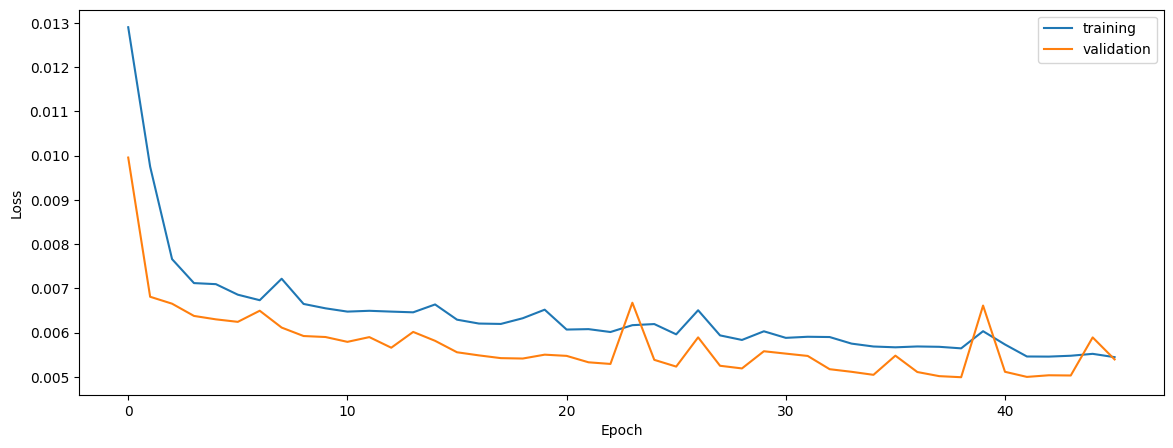

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.751470984616853
0.7518969977954814
0.7253139850550855


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.751470984616853
0.7518969977954814
0.7253139850550855


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7549460143410853
0.7607810313767513
0.7196486956787297


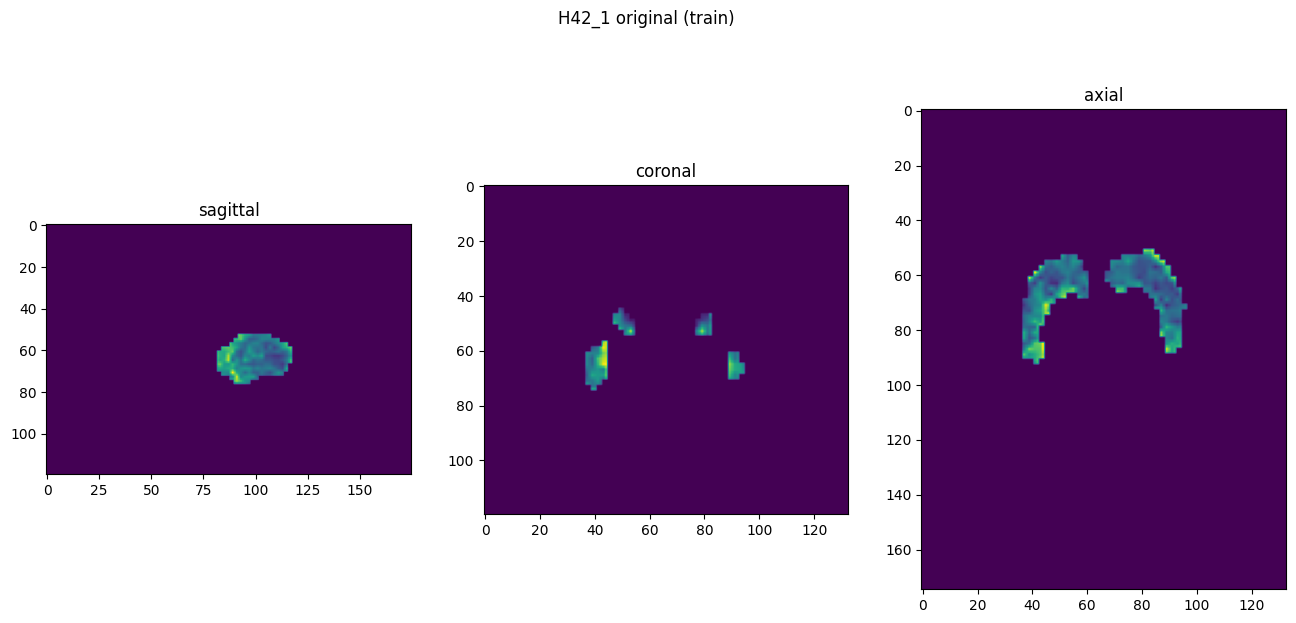

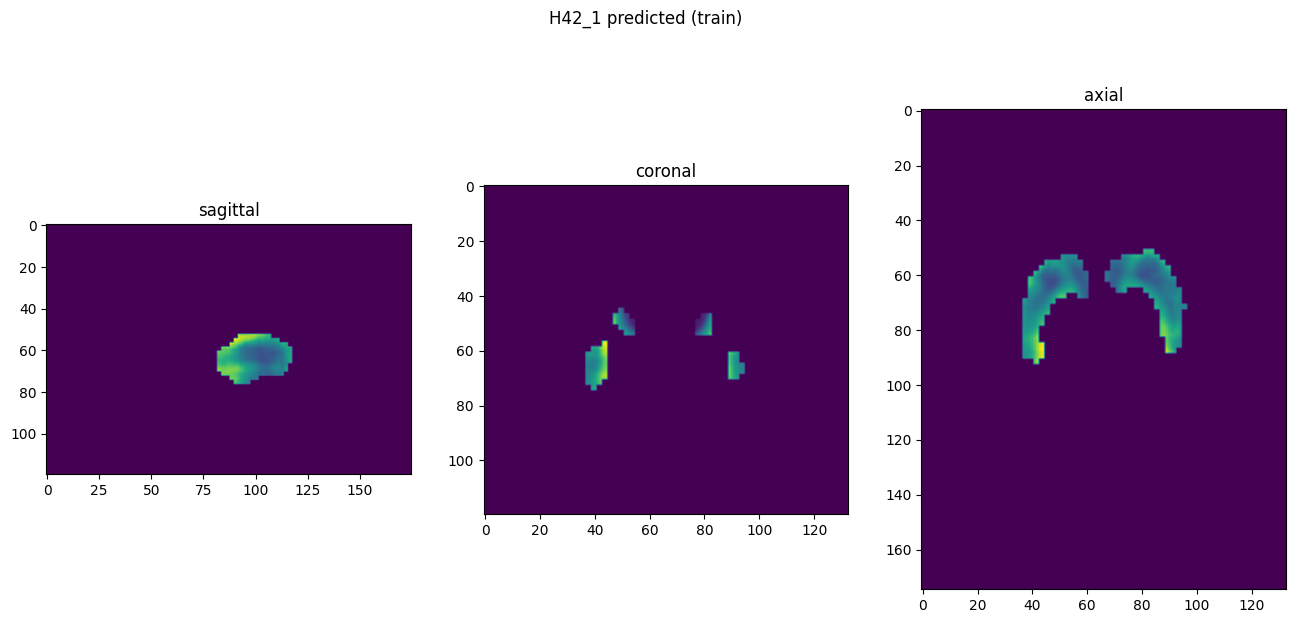

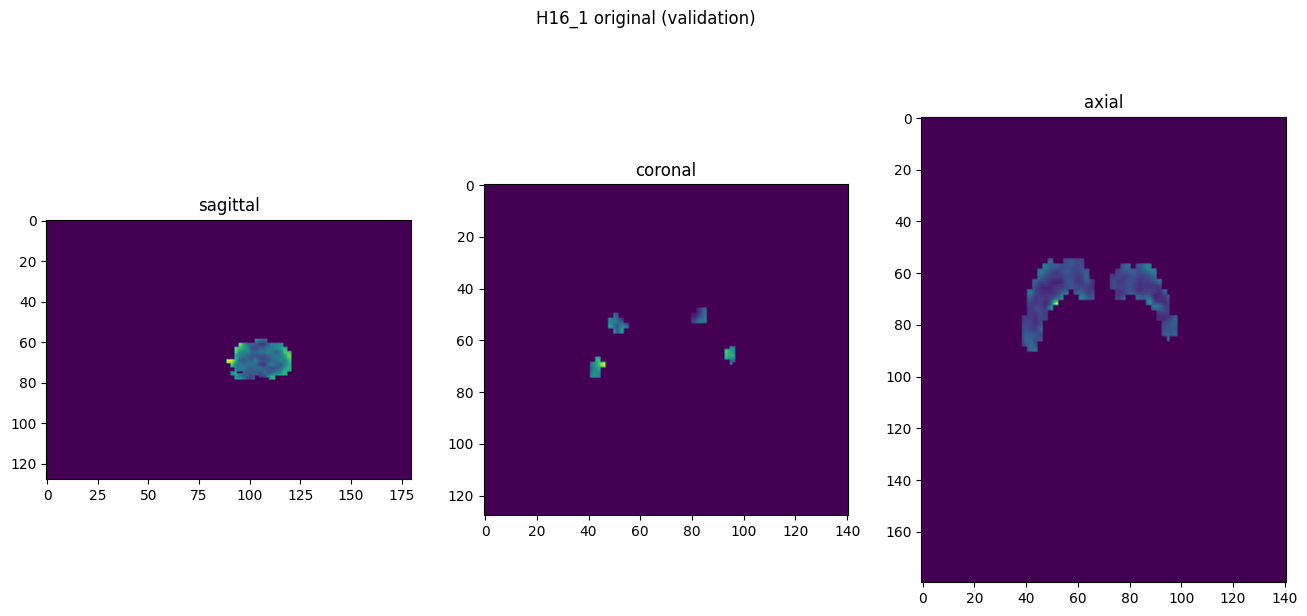

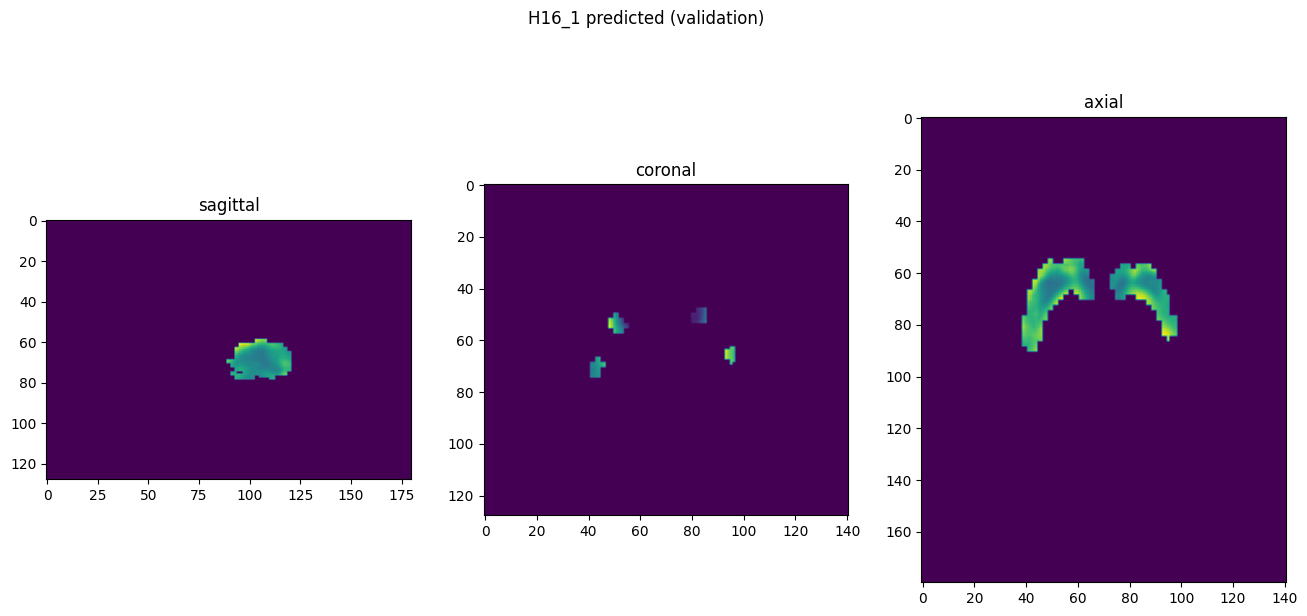

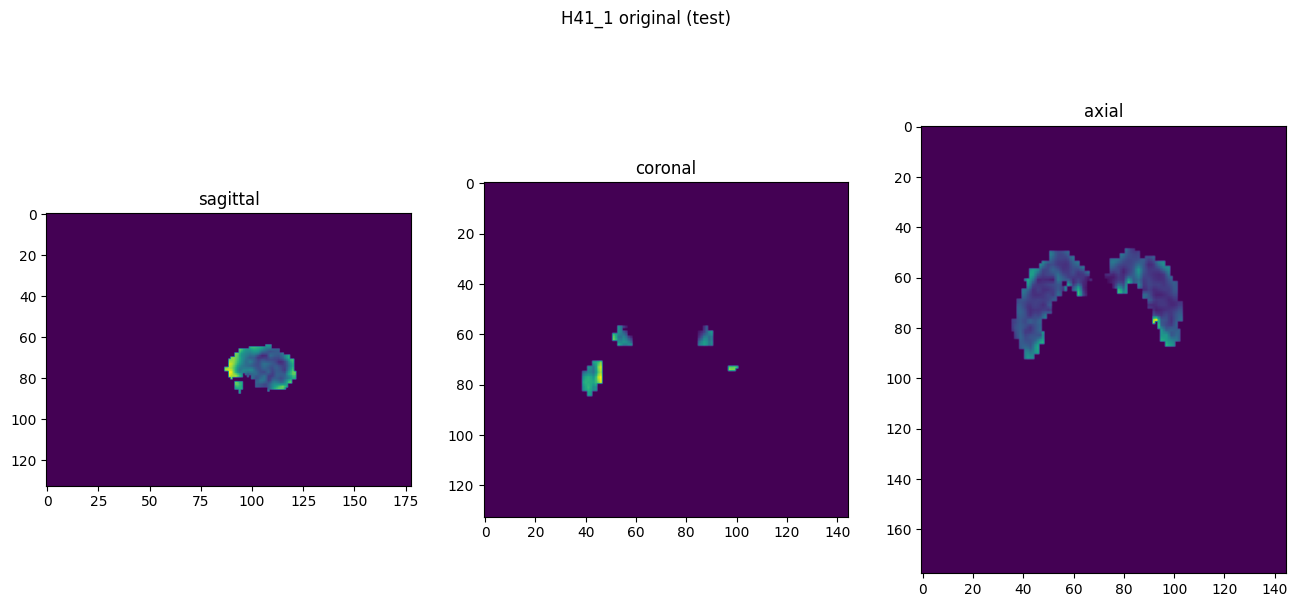

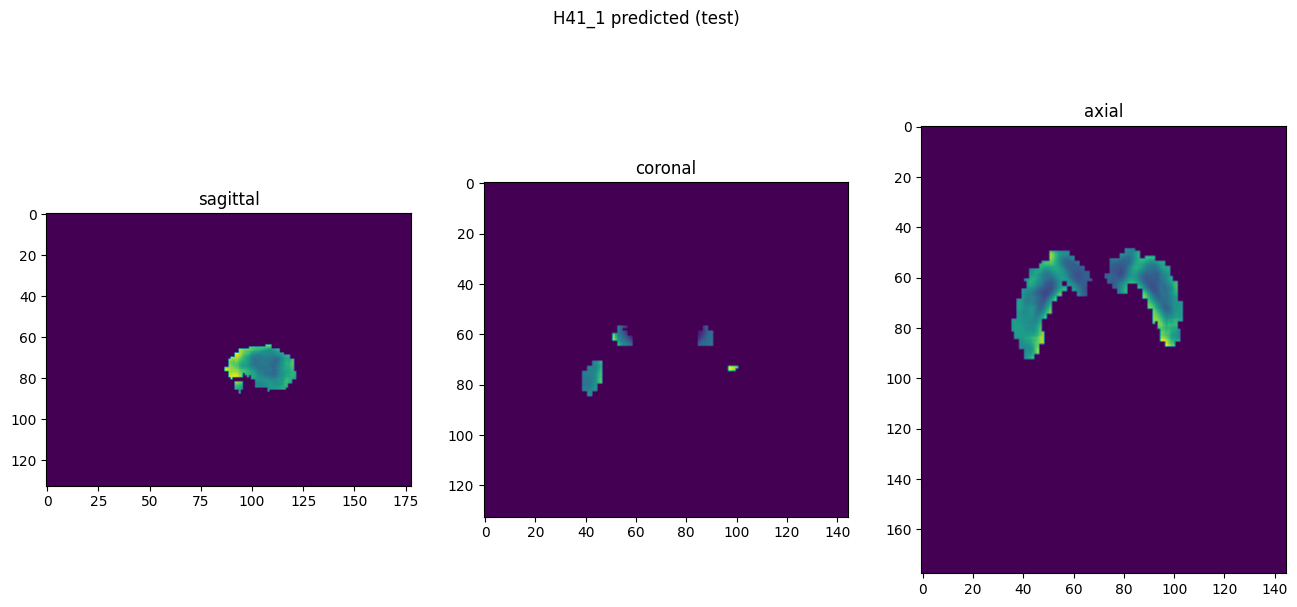

In [10]:
showResults(model, gen, threshold=None, background=False)